In [226]:
import os 
import random
import numpy as np

import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [227]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [228]:
model_ident = "bidiretional_lstm"
unique_iden = "epoch100_emb1024_xy"

main_dir = "D:\\FYP\\HAR-ZSL-XAI"
data_dir = os.path.join(main_dir,"data","sequence_data","random_50f")
epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
test_vids = os.path.join(main_dir,"test_vids")
class_names = os.listdir(data_dir)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 1-train_ratio - val_ratio
batch_size = 32

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

In [229]:
config = {
    "n_epochs":100,
    "model_name":"BidirectionalLSTM",
    "model":{
        "seq_len":50,
        "input_size":24,
        "hidden_size":512,
        "linear_filters":[128,256,512],
        "embedding_size":1024,
        "num_layers":1,
        "bidirectional":True,
        "batch_size":32,
        "dev":device
    }
}

In [230]:
def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [231]:
 class_names = os.listdir(os.path.join(main_dir,"data","skel_out","hmbd51"))

In [232]:
id2clsname, clsname2id = classname_id(class_names)

In [233]:
train_file_list = []
val_file_list = []
test_file_list = []

file_list = [os.path.join(data_dir,x) for x in os.listdir(data_dir)]

random.shuffle(file_list)
num_list = len(file_list)

train_range = [0,int(num_list*train_ratio)]
val_range = [int(num_list*train_ratio),int(num_list*(train_ratio+val_ratio))]
test_range = [int(num_list*(train_ratio+val_ratio)),num_list-1]

train_file_list += file_list[train_range[0]:train_range[1]]
val_file_list += file_list[val_range[0]:val_range[1]]
test_file_list += file_list[test_range[0]:test_range[1]]

In [234]:
len(train_file_list),len(val_file_list),len(test_file_list)

(6746, 1446, 1445)

In [235]:
train_file_list = train_file_list[:(len(train_file_list)//batch_size)*batch_size]
val_file_list = val_file_list[:(len(val_file_list)//batch_size)*batch_size]
test_file_list = test_file_list[:(len(test_file_list)//batch_size)*batch_size]

In [236]:
len(train_file_list),len(val_file_list),len(test_file_list)

(6720, 1440, 1440)

In [237]:
class SkeletonDataset(Dataset):
    def __init__(self, file_list,class2id, transform=None, 
                 target_transform=None,active_locations=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],file_name=False, is_2d=False):
        self.file_list = file_list
        self.transform = transform
        self.class2id = class2id
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name
        self.is_2d = is_2d

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        a_file = np.load(self.file_list[idx])
        action_type = self.file_list[idx].strip().split(os.path.sep)[-1].split("_cls_")[0]
        coords, vid_size = a_file["coords"],a_file["video_size"]
        coords = coords[:,self.active_locations,:]

        if self.is_2d:
            coords = coords[...,0:2]

        shape = coords.shape

        coords = torch.from_numpy(coords).float()

        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)

        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        if self.file_name:
            return coords, label, self.class2id[action_type],a_file["video_size"],self.file_list[idx]
        return coords, label, self.class2id[action_type],a_file["video_size"]

In [238]:
train_data = SkeletonDataset(train_file_list,clsname2id,is_2d=True)
val_data = SkeletonDataset(val_file_list,clsname2id,is_2d=True)
test_data = SkeletonDataset(test_file_list,clsname2id,is_2d=True)

In [239]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [240]:
for x in train_dl:
    print(x[0].shape)
    break

torch.Size([32, 50, 24])


In [241]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev=dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.cat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((-1,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
            bs = h.size()[1]
        else:
            hidden = encoder_hidden.view((-1,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
            bs = h.size()[1]
        
        dummy_input = torch.rand((bs,self.seq_len,self.hidden_size), requires_grad=True).to(self.dev)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [242]:
encoder = BiLSTMEncoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"]).to(device)

decoder = BiLSTMDecoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"]).to(device)

bilstm_model = BiLSTMEncDecModel(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"])

In [243]:
bilstm_model.to(device)

BiLSTMEncDecModel(
  (encoder): BiLSTMEncoder(
    (lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=24, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
    )
    (out_linear): Linear(in_features=2048, out_features=1024, bias=True)
  )
  (decoder): BiLSTMDecoder(
    (input_linear): Linear(in_features=1024, out_features=2048, bias=True)
    (lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=24, bias=True)
    )
  )
)

In [244]:
lstm_out, embedding = encoder(torch.randn((32,50,24)).to(device))

In [245]:

embedding.shape

torch.Size([32, 1024])

In [246]:
decoder_out = decoder(embedding)

In [247]:
model_out,embedding = bilstm_model(torch.randn((32,50,24)).to(device))

In [248]:
model_out.shape

torch.Size([32, 50, 24])

In [249]:
model_out,embedding = bilstm_model(torch.randn((16,50,24)).to(device))

In [250]:
model_out.shape

torch.Size([16, 50, 24])

In [251]:
model_out,embedding = bilstm_model(torch.randn((5,50,24)).to(device))

In [252]:
model_out.shape

torch.Size([5, 50, 24])

In [253]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_skeleton(frame, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles
    for coord in frame:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add lines
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line
        st = frame[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))

        en = frame[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))

        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 0, 0), thickness=3)

    return img_3

def gen_skeletons(frame1 , frame2, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles for the frame-set-1
    for coord in frame1:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add circles for the frame-set-2
    for coord in frame2:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(0, 255, 0), thickness=6)

    # add lines
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line

        st = frame1[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))
        en = frame1[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))
        img3_ = cv2.line(img_3, start_point, end_point, color=(250, 0, 0), thickness=3)

        st = frame2[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))
        en = frame2[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))
        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 250, 0), thickness=3)

    return img_3

def gen_video(points, save_file, frame_h, frame_w):
    # make 3D if points are flatten
    if len(points.shape) == 2:
        fts = points.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points = np.transpose(np.array([points[:, x_cds], points[:, y_cds], points[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame in enumerate(points):
        skel_image = gen_skeleton(frame, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_cmp_video(points1, points2, save_file, frame_h, frame_w):
    # make 3D if points are flatten
    if len(points1.shape) == 2:
        fts = points1.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points1 = np.transpose(np.array([points1[:, x_cds], points1[:, y_cds], points1[:, z_cds]]), (1,2,0))

    if len(points2.shape) == 2:
        fts = points2.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points2 = np.transpose(np.array([points2[:, x_cds], points2[:, y_cds], points2[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame_1 in enumerate(points1):
        frame_2 = points2[__id]
        skel_image = gen_skeletons(frame_1, frame_2, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_random_video(model,dataset,epoch,batch_size,model_name=model_ident,unique_name=unique_iden):
    ind = random.randint(0,len(dataset)-1)
    batch_sel = random.randint(0,batch_size-1)

    in_seq,tar_seq,action,vid_size = dataset[ind]
    pred_seq, _ = model(in_seq.repeat(batch_size,1,1).to(device))

    os.makedirs(f"{epoch_vids}/{model_name}/{unique_name}/{epoch}",exist_ok=True)
    gen_video(pred_seq[batch_sel].squeeze().cpu().detach().numpy(),f"{epoch_vids}/{model_name}/{unique_name}/{epoch}/pred.mp4",int(vid_size[0]),int(vid_size[1]))
    gen_video(in_seq.detach().numpy(),f"{epoch_vids}/{model_name}/{unique_name}/{epoch}/true.mp4",int(vid_size[0]),int(vid_size[1]))

def save_history(history,model_name,unique_name):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)

    with open(f"{PATH}/{unique_name}.json","w+") as f0:
        json.dump(history,f0)

def save_model(model,model_name,unique_name):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "model_config": config["model"],
        "config":config
    }, f"{PATH}/{unique_name}.pt")

In [254]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    std_loss = nn.L1Loss(reduction='mean').to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for in_seq,tar_seq,action,vid_size in tqdm(train_dataset):
            optimizer.zero_grad()
            
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred,_  = model(in_seq)
            
            loss = std_loss(seq_pred, tar_seq)
            #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
            #print(contrastive_loss(embed,labels=sample_label.view(-1)))

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for in_seq,tar_seq,action,vid_size in val_dataset:

                in_seq = in_seq.to(device)
                tar_seq = tar_seq.to(device)
                seq_pred,_  = model(in_seq)

                loss = std_loss(seq_pred, tar_seq)
                #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
                val_losses.append(loss.item())

            #gen_random_video(model,val_data,epoch,batch_size,model_name=model_ident,unique_name=unique_iden)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    save_model(model,model_ident,unique_iden)
    return model.eval(), history

In [255]:
model, history = train_model(
  bilstm_model, 
  train_dl, 
  val_dl, 
  n_epochs=100
)

100%|██████████| 210/210 [00:41<00:00,  5.11it/s]


Epoch 1: train loss 0.16137179303027335 val loss 0.10816207047965791


100%|██████████| 210/210 [00:21<00:00,  9.56it/s]


Epoch 2: train loss 0.0992868114440214 val loss 0.09473042438427608


100%|██████████| 210/210 [00:23<00:00,  9.06it/s]


Epoch 3: train loss 0.08896197286390123 val loss 0.0858824051088757


100%|██████████| 210/210 [00:23<00:00,  8.79it/s]


Epoch 4: train loss 0.08176748914023241 val loss 0.07924787311090363


100%|██████████| 210/210 [00:24<00:00,  8.44it/s]


Epoch 5: train loss 0.07621198369278795 val loss 0.06976876366469595


100%|██████████| 210/210 [00:25<00:00,  8.14it/s]


Epoch 6: train loss 0.07159614314635594 val loss 0.06542785813411077


100%|██████████| 210/210 [00:26<00:00,  7.81it/s]


Epoch 7: train loss 0.06826039577523867 val loss 0.0680782718790902


100%|██████████| 210/210 [00:29<00:00,  7.19it/s]


Epoch 8: train loss 0.06467313899525574 val loss 0.06657297296656503


100%|██████████| 210/210 [00:28<00:00,  7.42it/s]


Epoch 9: train loss 0.06214070822156611 val loss 0.06376709813872973


100%|██████████| 210/210 [00:28<00:00,  7.27it/s]


Epoch 10: train loss 0.06042320359320868 val loss 0.06116421893239021


100%|██████████| 210/210 [00:29<00:00,  7.18it/s]


Epoch 11: train loss 0.05932409202768689 val loss 0.0640403484304746


100%|██████████| 210/210 [00:29<00:00,  7.09it/s]


Epoch 12: train loss 0.055621873835722604 val loss 0.06273272426591979


100%|██████████| 210/210 [00:30<00:00,  6.97it/s]


Epoch 13: train loss 0.05507440852622191 val loss 0.056730576935741635


100%|██████████| 210/210 [00:30<00:00,  6.84it/s]


Epoch 14: train loss 0.05441423172042483 val loss 0.053764444258477956


100%|██████████| 210/210 [00:31<00:00,  6.75it/s]


Epoch 15: train loss 0.05290039722763357 val loss 0.052074902918603685


100%|██████████| 210/210 [00:31<00:00,  6.64it/s]


Epoch 16: train loss 0.05100107400545052 val loss 0.05197846964001655


100%|██████████| 210/210 [00:31<00:00,  6.66it/s]


Epoch 17: train loss 0.05139949508011341 val loss 0.05249424104889234


100%|██████████| 210/210 [00:31<00:00,  6.60it/s]


Epoch 18: train loss 0.0495893202367283 val loss 0.049222083803680206


100%|██████████| 210/210 [00:32<00:00,  6.40it/s]


Epoch 19: train loss 0.04817490226456097 val loss 0.05506890333361096


100%|██████████| 210/210 [00:32<00:00,  6.41it/s]


Epoch 20: train loss 0.04812310517189049 val loss 0.04992809949649705


100%|██████████| 210/210 [00:33<00:00,  6.25it/s]


Epoch 21: train loss 0.04753630276592005 val loss 0.04920353078179889


100%|██████████| 210/210 [00:33<00:00,  6.24it/s]


Epoch 22: train loss 0.04773970925736995 val loss 0.05117341495222515


100%|██████████| 210/210 [00:33<00:00,  6.27it/s]


Epoch 23: train loss 0.045953962809982755 val loss 0.04887307617399428


100%|██████████| 210/210 [00:33<00:00,  6.33it/s]


Epoch 24: train loss 0.04464558490685054 val loss 0.04837930351495743


100%|██████████| 210/210 [00:33<00:00,  6.27it/s]


Epoch 25: train loss 0.04453601265947024 val loss 0.04602704503469997


100%|██████████| 210/210 [00:33<00:00,  6.28it/s]


Epoch 26: train loss 0.04470781041752724 val loss 0.047024870498312846


100%|██████████| 210/210 [00:34<00:00,  6.17it/s]


Epoch 27: train loss 0.04261439431990896 val loss 0.04254603990250164


100%|██████████| 210/210 [00:33<00:00,  6.33it/s]


Epoch 28: train loss 0.042466572743086586 val loss 0.04591351830297046


100%|██████████| 210/210 [00:33<00:00,  6.35it/s]


Epoch 29: train loss 0.04325155294722035 val loss 0.04290754588113891


100%|██████████| 210/210 [00:33<00:00,  6.26it/s]


Epoch 30: train loss 0.04158548294078736 val loss 0.04760103871424993


100%|██████████| 210/210 [00:33<00:00,  6.26it/s]


Epoch 31: train loss 0.04068895072809287 val loss 0.04058130991955598


100%|██████████| 210/210 [00:33<00:00,  6.27it/s]


Epoch 32: train loss 0.0409734843564885 val loss 0.04363981965515348


100%|██████████| 210/210 [00:35<00:00,  5.96it/s]


Epoch 33: train loss 0.04090929064190104 val loss 0.04073222345776028


100%|██████████| 210/210 [00:34<00:00,  6.14it/s]


Epoch 34: train loss 0.04093306307636556 val loss 0.041489650391870074


100%|██████████| 210/210 [00:32<00:00,  6.37it/s]


Epoch 35: train loss 0.03953028783379566 val loss 0.03915195659630828


100%|██████████| 210/210 [00:33<00:00,  6.31it/s]


Epoch 36: train loss 0.0403694224322126 val loss 0.04158705125252406


100%|██████████| 210/210 [00:33<00:00,  6.24it/s]


Epoch 37: train loss 0.03960981413367249 val loss 0.03901539983020889


100%|██████████| 210/210 [00:34<00:00,  6.13it/s]


Epoch 38: train loss 0.03949900937399694 val loss 0.04031671273211638


100%|██████████| 210/210 [00:33<00:00,  6.28it/s]


Epoch 39: train loss 0.03820081626375516 val loss 0.0418931122455332


100%|██████████| 210/210 [00:34<00:00,  6.17it/s]


Epoch 40: train loss 0.03742330525780008 val loss 0.041773141175508496


100%|██████████| 210/210 [00:33<00:00,  6.22it/s]


Epoch 41: train loss 0.03826567323967105 val loss 0.03919462867909008


100%|██████████| 210/210 [00:33<00:00,  6.29it/s]


Epoch 42: train loss 0.039115494463060584 val loss 0.03862895870374309


100%|██████████| 210/210 [00:33<00:00,  6.21it/s]


Epoch 43: train loss 0.03798114919059333 val loss 0.03973306823107931


100%|██████████| 210/210 [00:33<00:00,  6.24it/s]


Epoch 44: train loss 0.0381404172629118 val loss 0.04111646455195215


100%|██████████| 210/210 [00:33<00:00,  6.31it/s]


Epoch 45: train loss 0.037103046086572465 val loss 0.037953210829032795


100%|██████████| 210/210 [00:33<00:00,  6.28it/s]


Epoch 46: train loss 0.03632058385936987 val loss 0.03649158386720552


100%|██████████| 210/210 [00:33<00:00,  6.24it/s]


Epoch 47: train loss 0.035528306068763844 val loss 0.03794899301396476


100%|██████████| 210/210 [00:33<00:00,  6.21it/s]


Epoch 48: train loss 0.036111901851282234 val loss 0.03762091878387663


100%|██████████| 210/210 [00:34<00:00,  6.17it/s]


Epoch 49: train loss 0.03523635191931611 val loss 0.03800251090692149


100%|██████████| 210/210 [00:33<00:00,  6.23it/s]


Epoch 50: train loss 0.035780926660767626 val loss 0.03639472102125486


100%|██████████| 210/210 [00:33<00:00,  6.25it/s]


Epoch 51: train loss 0.03522053997786272 val loss 0.037943488856156664


100%|██████████| 210/210 [00:33<00:00,  6.24it/s]


Epoch 52: train loss 0.03505532279433239 val loss 0.037301249139838746


100%|██████████| 210/210 [00:33<00:00,  6.25it/s]


Epoch 53: train loss 0.035669211466752344 val loss 0.038140608825617366


100%|██████████| 210/210 [00:33<00:00,  6.30it/s]


Epoch 54: train loss 0.03475593222039086 val loss 0.03640762699974908


100%|██████████| 210/210 [00:33<00:00,  6.33it/s]


Epoch 55: train loss 0.03460989438352131 val loss 0.036368589972456296


100%|██████████| 210/210 [00:34<00:00,  6.08it/s]


Epoch 56: train loss 0.03438523993605659 val loss 0.03757328341404597


100%|██████████| 210/210 [00:33<00:00,  6.30it/s]


Epoch 57: train loss 0.03342762046626636 val loss 0.03406722189651595


100%|██████████| 210/210 [00:33<00:00,  6.31it/s]


Epoch 58: train loss 0.03330563841653722 val loss 0.03453240067594581


100%|██████████| 210/210 [00:33<00:00,  6.30it/s]


Epoch 59: train loss 0.034644424445217564 val loss 0.03478243259920014


100%|██████████| 210/210 [00:34<00:00,  6.01it/s]


Epoch 60: train loss 0.03308659511662665 val loss 0.03445659664769967


100%|██████████| 210/210 [00:32<00:00,  6.39it/s]


Epoch 61: train loss 0.03347700263063113 val loss 0.035120963884724514


100%|██████████| 210/210 [00:33<00:00,  6.30it/s]


Epoch 62: train loss 0.033070864625984714 val loss 0.03471267840100659


100%|██████████| 210/210 [00:33<00:00,  6.22it/s]


Epoch 63: train loss 0.03306540457443113 val loss 0.033687693625688554


100%|██████████| 210/210 [00:33<00:00,  6.30it/s]


Epoch 64: train loss 0.03445655333676508 val loss 0.03438487785557906


100%|██████████| 210/210 [00:34<00:00,  6.08it/s]


Epoch 65: train loss 0.03321182442208131 val loss 0.03280472565028403


100%|██████████| 210/210 [00:34<00:00,  6.12it/s]


Epoch 66: train loss 0.033234440810268835 val loss 0.03496000775032573


100%|██████████| 210/210 [00:33<00:00,  6.19it/s]


Epoch 67: train loss 0.03264222995688518 val loss 0.03376552735765775


100%|██████████| 210/210 [00:37<00:00,  5.53it/s]


Epoch 68: train loss 0.0328300618522224 val loss 0.032954007842474514


100%|██████████| 210/210 [00:33<00:00,  6.22it/s]


Epoch 69: train loss 0.032408182748726436 val loss 0.03545651055044598


100%|██████████| 210/210 [00:33<00:00,  6.22it/s]


Epoch 70: train loss 0.03191731425800494 val loss 0.03307132799592283


100%|██████████| 210/210 [00:33<00:00,  6.23it/s]


Epoch 71: train loss 0.03205780928865785 val loss 0.0329005844063229


100%|██████████| 210/210 [00:33<00:00,  6.23it/s]


Epoch 72: train loss 0.03146078252189216 val loss 0.033924511447548863


100%|██████████| 210/210 [00:33<00:00,  6.21it/s]


Epoch 73: train loss 0.031478826621813435 val loss 0.03387029796010918


100%|██████████| 210/210 [00:33<00:00,  6.21it/s]


Epoch 74: train loss 0.03205748773401692 val loss 0.034953847941425115


100%|██████████| 210/210 [00:33<00:00,  6.21it/s]


Epoch 75: train loss 0.03143284454764355 val loss 0.03217527142001523


100%|██████████| 210/210 [00:34<00:00,  6.17it/s]


Epoch 76: train loss 0.030771400398086932 val loss 0.03261010369492902


100%|██████████| 210/210 [00:33<00:00,  6.25it/s]


Epoch 77: train loss 0.031132566662771363 val loss 0.03288710316022237


100%|██████████| 210/210 [00:33<00:00,  6.23it/s]


Epoch 78: train loss 0.031024623059091115 val loss 0.032753436432944406


100%|██████████| 210/210 [00:33<00:00,  6.20it/s]


Epoch 79: train loss 0.03150865523410695 val loss 0.03335669144160218


100%|██████████| 210/210 [00:34<00:00,  6.03it/s]


Epoch 80: train loss 0.03122561900388627 val loss 0.033695015807946524


100%|██████████| 210/210 [00:33<00:00,  6.25it/s]


Epoch 81: train loss 0.03142682846103396 val loss 0.03221325932277574


100%|██████████| 210/210 [00:33<00:00,  6.25it/s]


Epoch 82: train loss 0.030680220547531334 val loss 0.03175915458963977


100%|██████████| 210/210 [00:34<00:00,  6.11it/s]


Epoch 83: train loss 0.030409722464780013 val loss 0.033308014397819836


100%|██████████| 210/210 [00:33<00:00,  6.23it/s]


Epoch 84: train loss 0.030742984664227282 val loss 0.03167532260219256


100%|██████████| 210/210 [00:33<00:00,  6.27it/s]


Epoch 85: train loss 0.03074615935661963 val loss 0.033231476239032214


100%|██████████| 210/210 [00:34<00:00,  6.18it/s]


Epoch 86: train loss 0.030406272730657033 val loss 0.0311834879219532


100%|██████████| 210/210 [00:33<00:00,  6.20it/s]


Epoch 87: train loss 0.02958711101895287 val loss 0.03048120451470216


100%|██████████| 210/210 [00:33<00:00,  6.18it/s]


Epoch 88: train loss 0.02966729618076767 val loss 0.030675642978813915


100%|██████████| 210/210 [00:33<00:00,  6.26it/s]


Epoch 89: train loss 0.02944717002766473 val loss 0.031201568411456215


100%|██████████| 210/210 [00:34<00:00,  6.16it/s]


Epoch 90: train loss 0.029826048921261516 val loss 0.03204720227254761


100%|██████████| 210/210 [00:33<00:00,  6.18it/s]


Epoch 91: train loss 0.029877424896472975 val loss 0.032598693793018656


100%|██████████| 210/210 [00:33<00:00,  6.21it/s]


Epoch 92: train loss 0.030332368372806482 val loss 0.03339681538442771


100%|██████████| 210/210 [00:33<00:00,  6.34it/s]


Epoch 93: train loss 0.03032512217760086 val loss 0.030325637674993938


100%|██████████| 210/210 [00:34<00:00,  6.15it/s]


Epoch 94: train loss 0.030340640308956304 val loss 0.03303570772210757


100%|██████████| 210/210 [00:33<00:00,  6.29it/s]


Epoch 95: train loss 0.029109376784236658 val loss 0.030697711474365657


100%|██████████| 210/210 [00:33<00:00,  6.23it/s]


Epoch 96: train loss 0.02944390611456973 val loss 0.031451523676514624


100%|██████████| 210/210 [00:33<00:00,  6.18it/s]


Epoch 97: train loss 0.029038537134017262 val loss 0.030112063056892818


100%|██████████| 210/210 [00:33<00:00,  6.23it/s]


Epoch 98: train loss 0.02925352209380695 val loss 0.03402456852296988


100%|██████████| 210/210 [00:33<00:00,  6.33it/s]


Epoch 99: train loss 0.029090493580415135 val loss 0.031075418492158256


100%|██████████| 210/210 [00:34<00:00,  6.13it/s]


Epoch 100: train loss 0.02977067552329529 val loss 0.03126039596067535


In [256]:
save_history(history,model_ident,unique_iden)

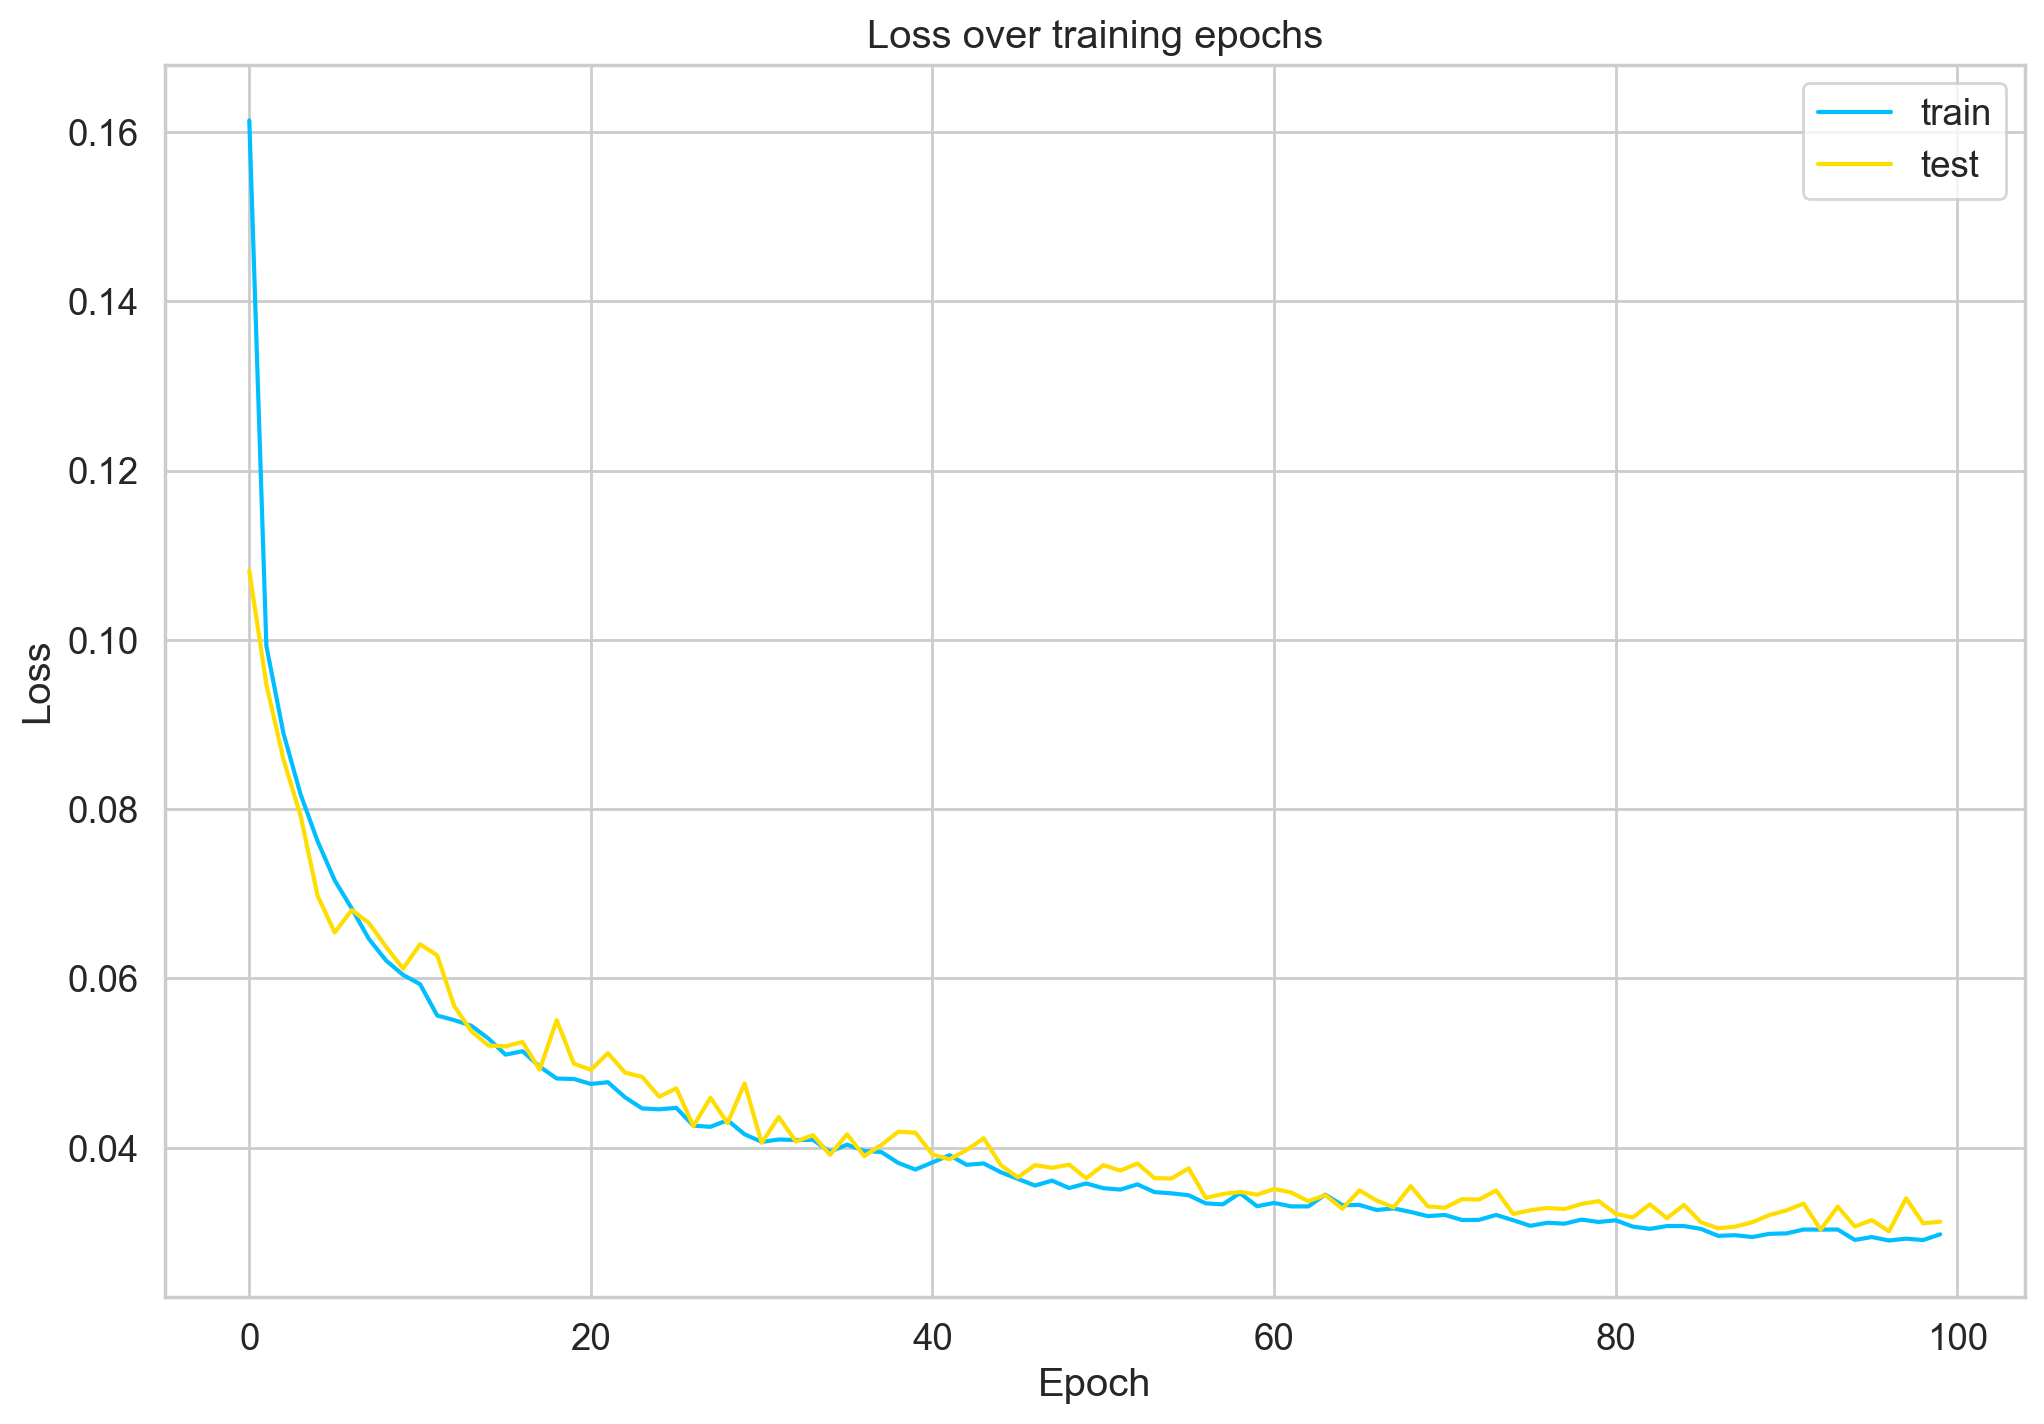

In [257]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [258]:
embedding_list = {}
output_list = {}
with torch.no_grad():
    for in_seq,tar_seq,action,vid_size in tqdm(test_dl):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for seq,emb,action in zip(seq_pred.unbind(0),embedding.unbind(0),action.unbind(0)):
                try:
                    if len(embedding_list[int(action)])<=50:
                        embedding_list[int(action)].append(emb)
                        output_list[int(action)].append(seq)
                except KeyError:
                    embedding_list[int(action)] = [emb]
                    output_list[int(action)] = [emb]

        
            
        
        #embedding_list[]

100%|██████████| 45/45 [00:07<00:00,  5.66it/s]


In [259]:
def draw_heatmaps(arr_list,nrows=2,ncols=2):
    ran_list = random.sample(arr_list,ncols*nrows)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharex=True)
    for i in range(nrows):
        for j in range(ncols):
            #print(i*ncols+j,len(ran_list))
            ax[i,j].imshow(ran_list[i*ncols+j].detach().cpu().numpy()[np.newaxis,:], cmap="plasma", aspect="auto")

    plt.tight_layout()
    plt.show()

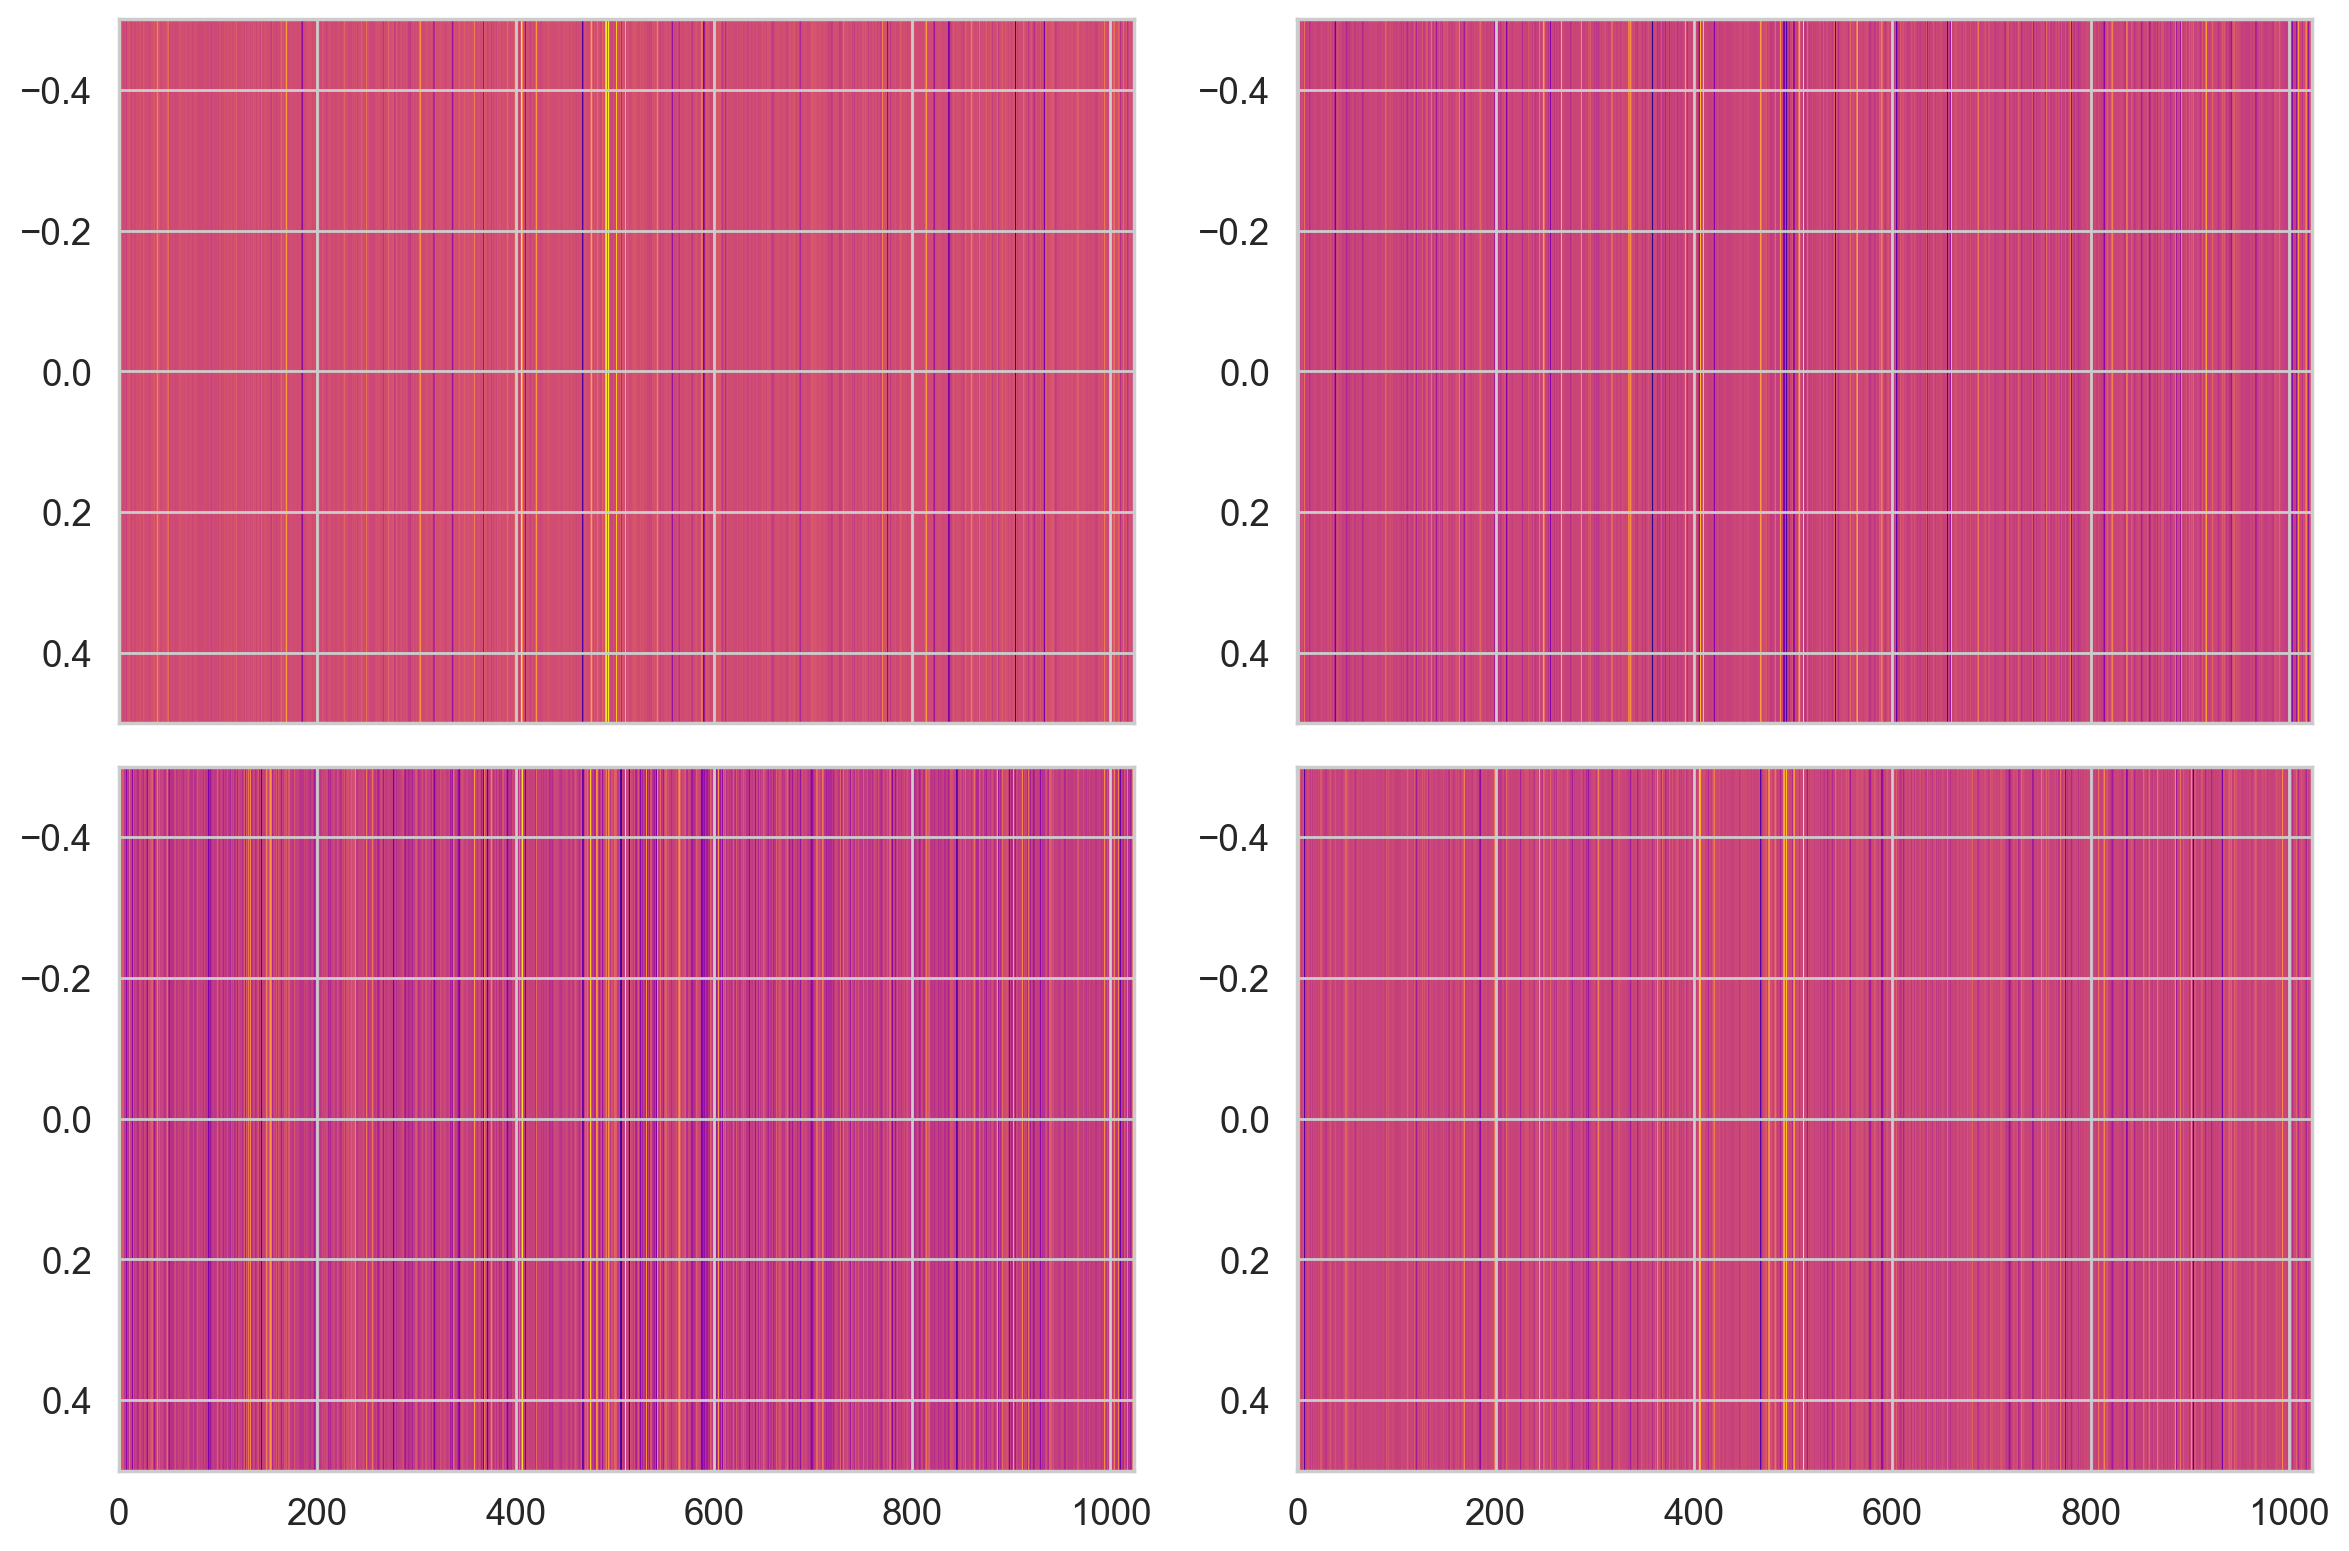

In [260]:
draw_heatmaps(embedding_list[11])

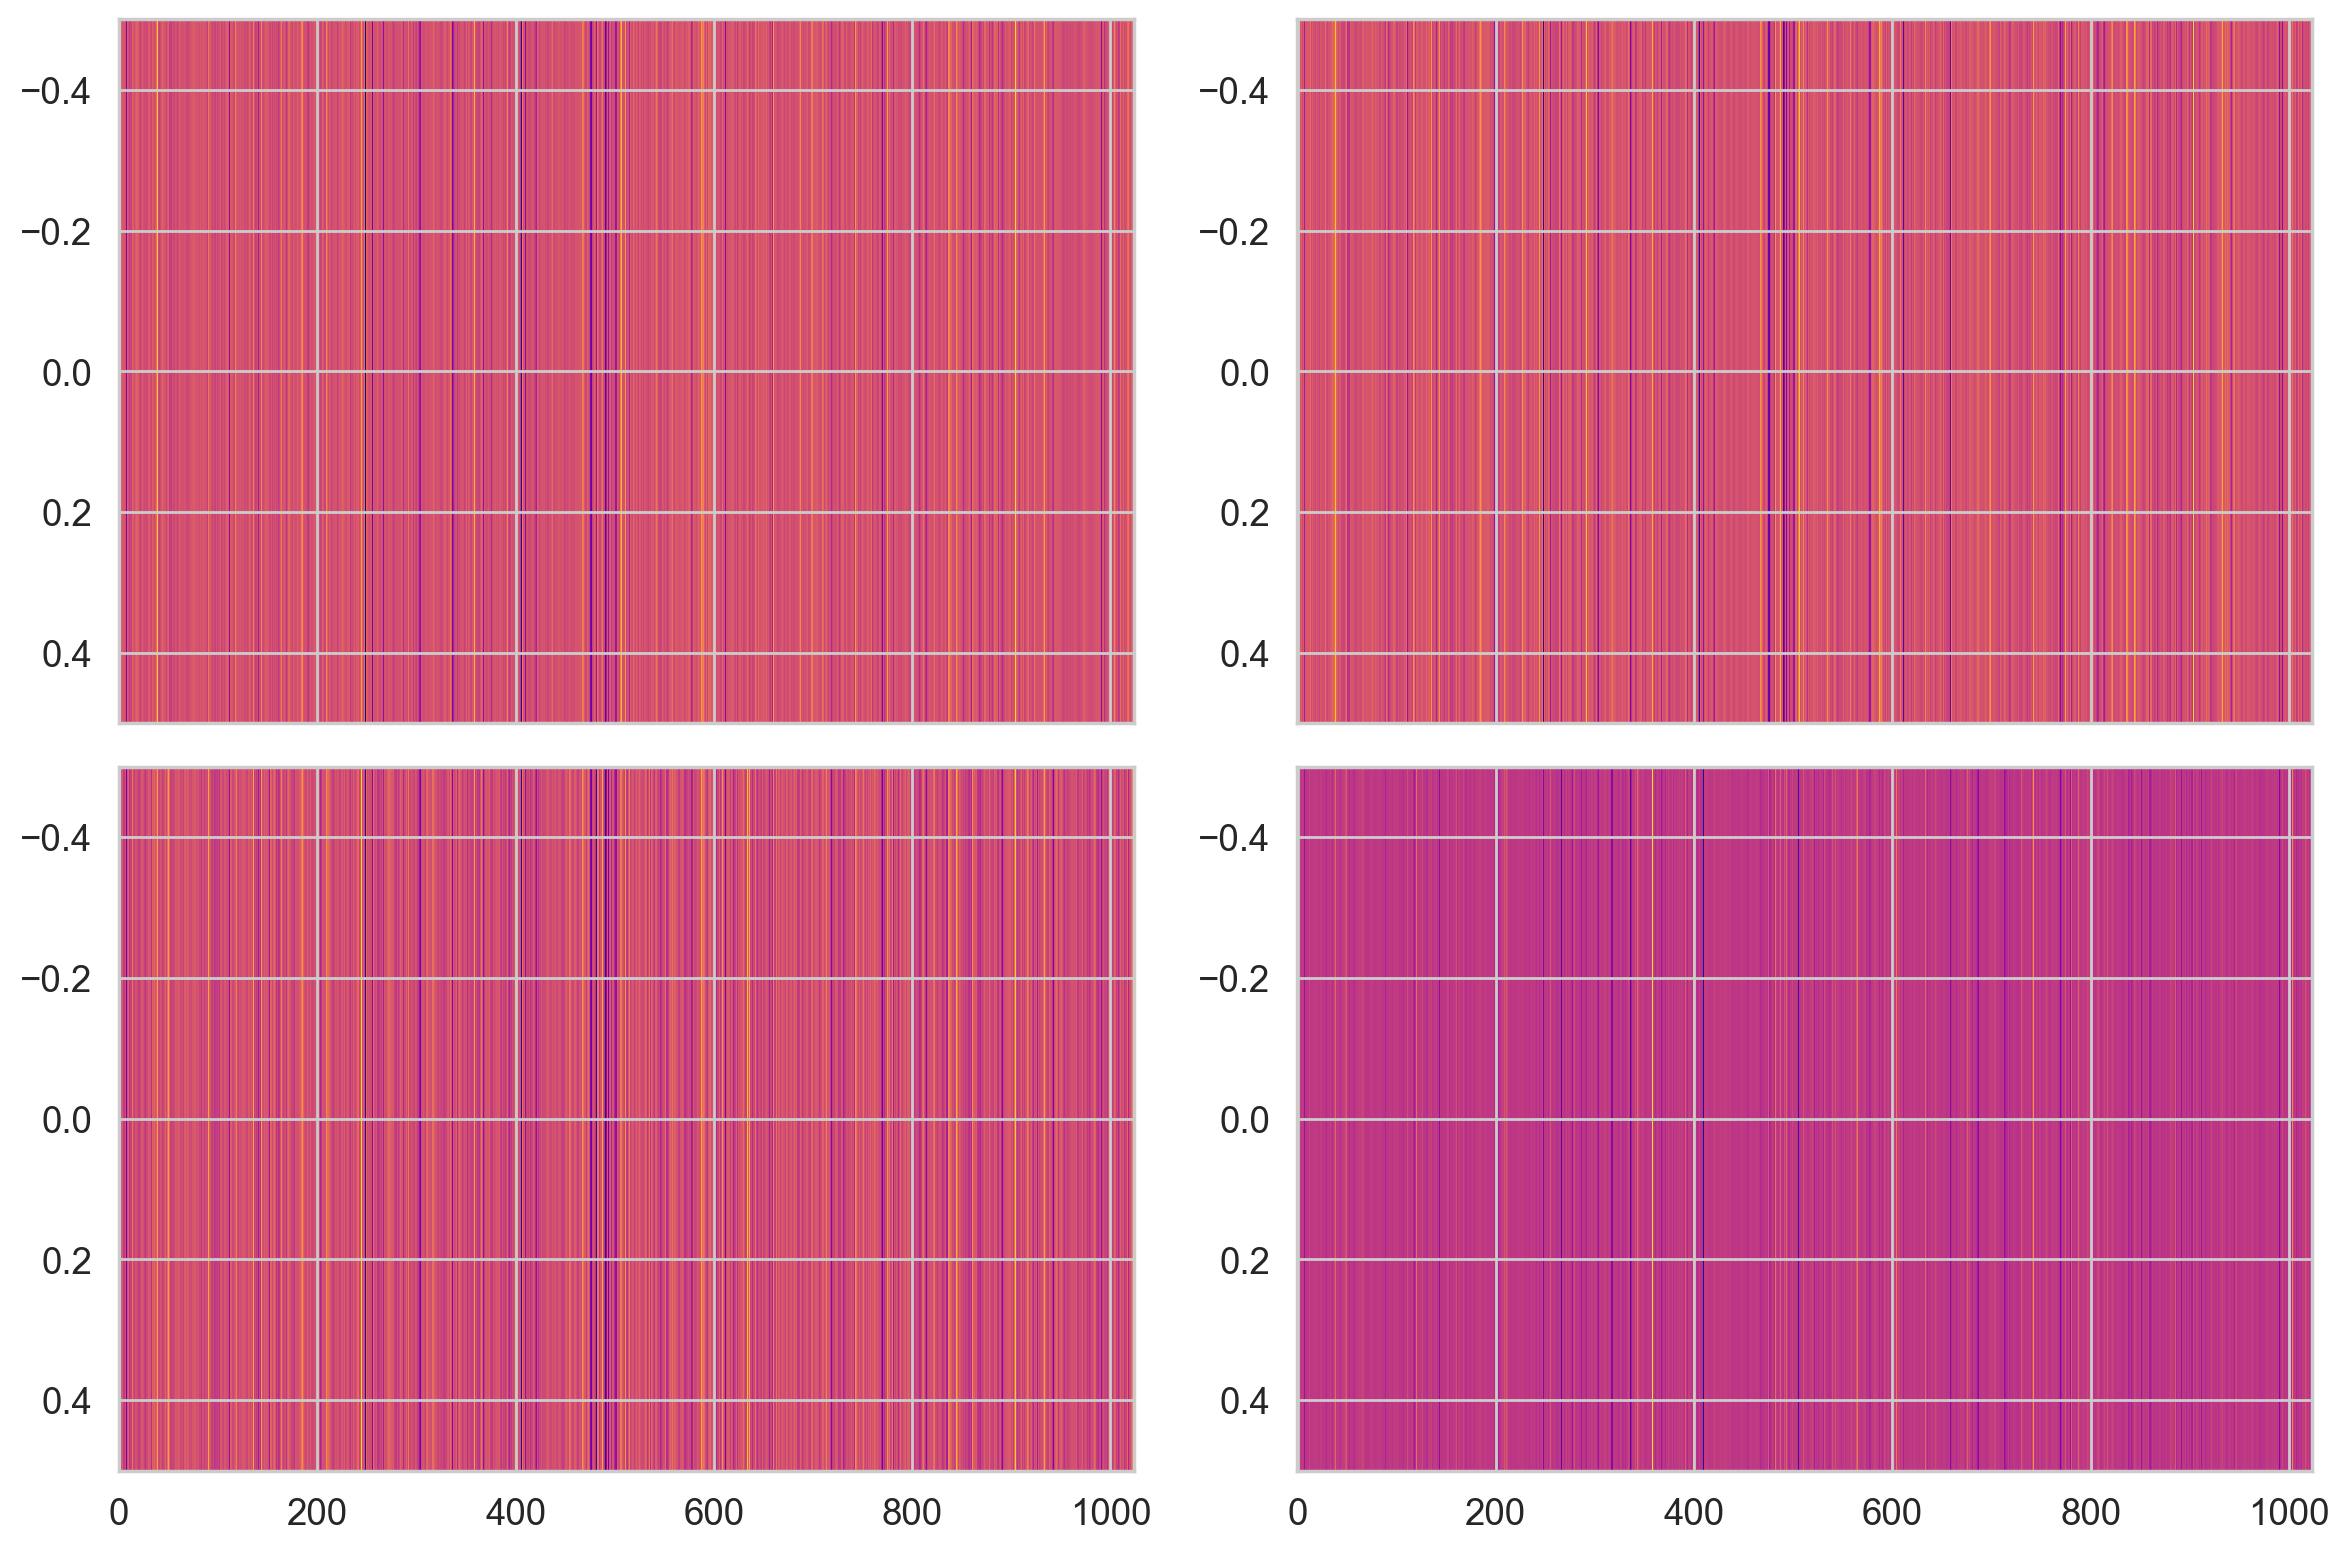

In [261]:
draw_heatmaps(embedding_list[22])

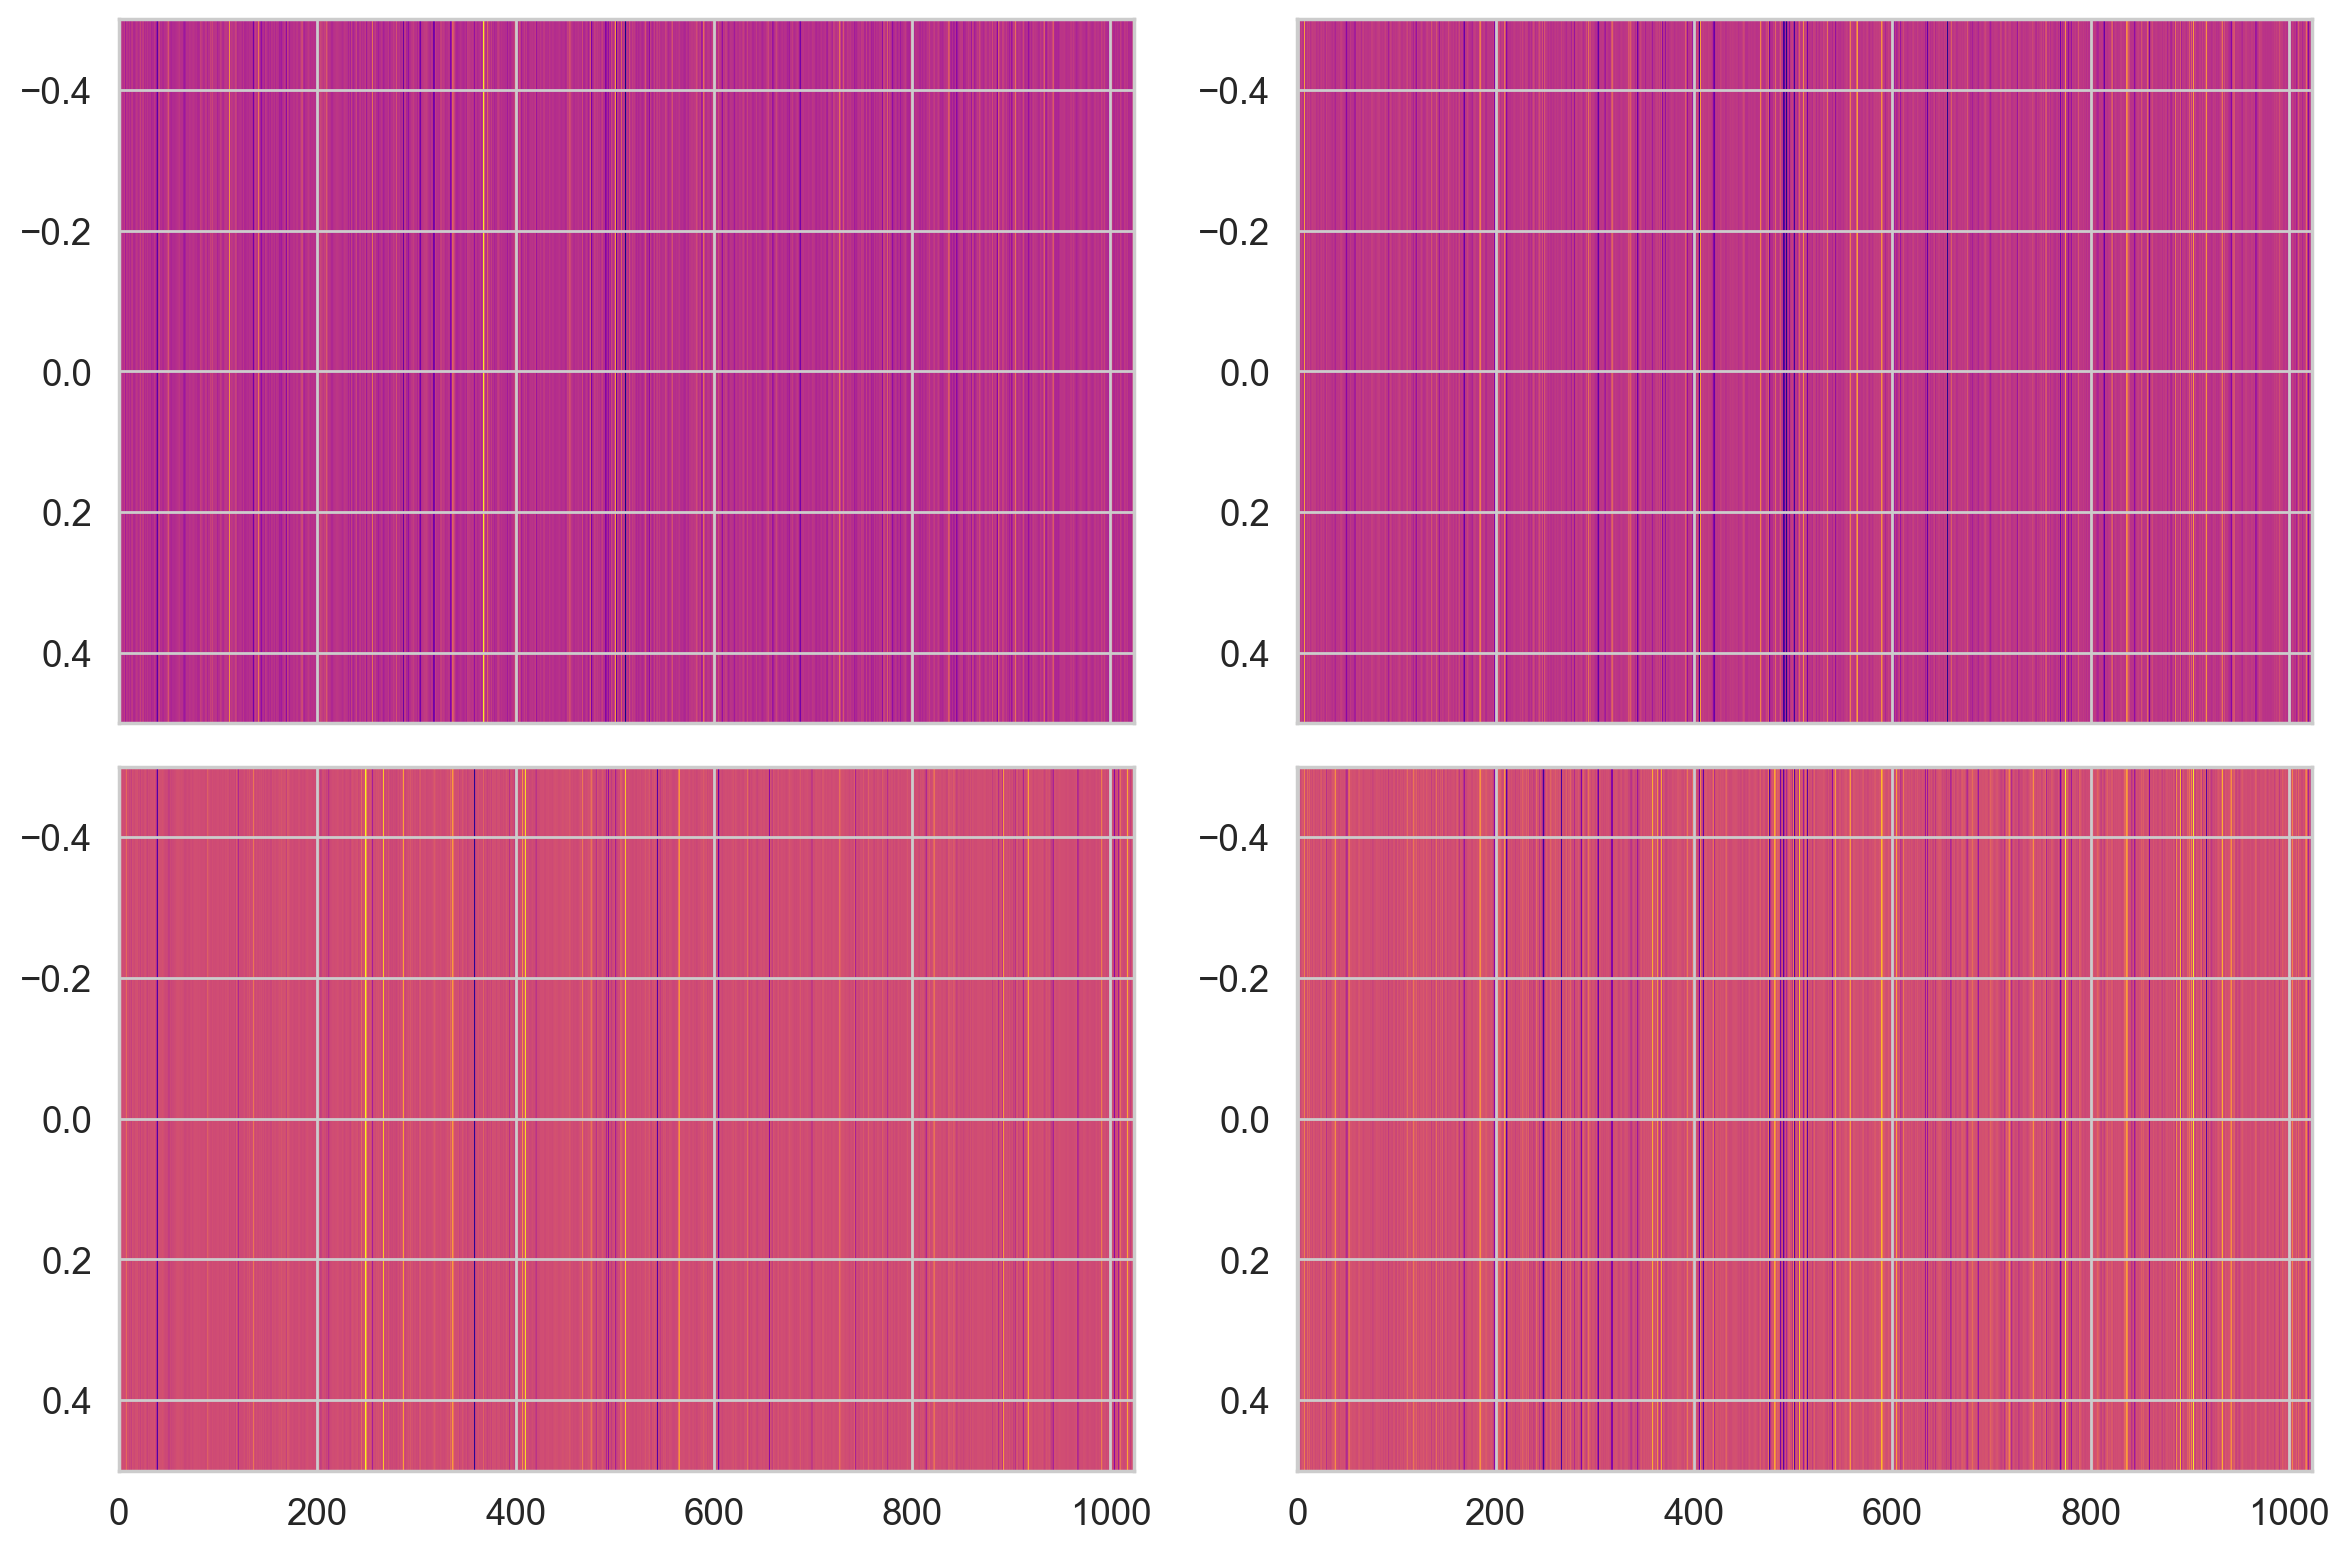

In [262]:
draw_heatmaps(embedding_list[16])

In [263]:
def gen_video_from_embeddings(embedding,model,save_file):
    seq_out = model.decoder(embedding.repeat(batch_size,1,1))
    gen_video(seq_out[0].detach().numpy(), save_file, 400, 400)

In [264]:
with torch.no_grad():
    for __id,(in_seq,tar_seq,action,vid_size) in tqdm(enumerate(test_dl)):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for __id,(input_vid,output_vid,action) in enumerate(zip(in_seq.unbind(0),seq_pred.unbind(0),action.unbind(0))):
            os.makedirs(f"{test_vids}/{int(action)}",exist_ok=True)

            

        
            
        
        #embedding_list[]

45it [00:03, 11.95it/s]


In [265]:
gen_video_from_embeddings(embedding_list[4][10],model,"embed_video.mp4")

IndexError: list index out of range

In [ ]:
test_emb = 0.5*embedding_list[19][0]+0.5*embedding_list[16][0]
gen_video_from_embeddings(test_emb,model,"test_embed_video.mp4")